In [60]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from pycocotools import mask as mask_utils
from PIL import Image
from torch.utils.data import Dataset
import json
import requests
import os


%matplotlib inline

In [61]:
class SA1BDataset(Dataset):
    def __init__(self, img_dir, ann_dir, mask_pixels_present=0.1, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir), key=lambda x: int(x.split('.')[0][3:]))
        self.mask_pixels_present = mask_pixels_present

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """
        
        :param idx: 
        :return: img: image in HWC
                 masks: masks in shape (num_masks, H, W), which sorted by area, decreasing order
                 point_coords: coordinates in shape (num_mask, num_coords, 2) relevant to masks
        """
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)
        img_num_pixels = img.shape[0] * img.shape[1]
        min_mask_pixels = self.mask_pixels_present * img_num_pixels

        ann_path = os.path.join(self.ann_dir, img_name.replace('.jpg', '.json'))
        with open(ann_path, 'r') as f:
            ann_data = json.load(f)

        masks_RLE = []
        crop_boxes = []
        point_coords = []

        ann_data["annotations"] = sorted(ann_data["annotations"], key=lambda x: x["area"], reverse=True)
        for ann in ann_data["annotations"]:
            masks_RLE.append(ann["segmentation"])
            crop_boxes.append(ann["crop_box"])
            point_coords.append(ann["point_coords"])

        masks = mask_utils.decode(masks_RLE)  # [H, W, num_masks]
        masks = masks.transpose(2, 0, 1)  # [num_masks, H, W]
        # 将掩码、裁剪框和点坐标转换为Tensor

        img = torch.from_numpy(img).float()  # [H, W, C]
        masks = torch.from_numpy(masks).float()
        point_coords = torch.tensor(point_coords).float()

        if self.transform:
            img = self.transform(img)

        return img, masks, point_coords


# 数据转换
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


In [62]:
from torch.utils.data import DataLoader

dataset = SA1BDataset(img_dir='SA-1B/images', ann_dir='SA-1B/annotations')

img, gt_masks, point_coords = dataset[5]
print(img.shape)
print(gt_masks.shape, point_coords.shape)




torch.Size([1500, 2254, 3])
torch.Size([85, 1500, 2254]) torch.Size([85, 1, 2])


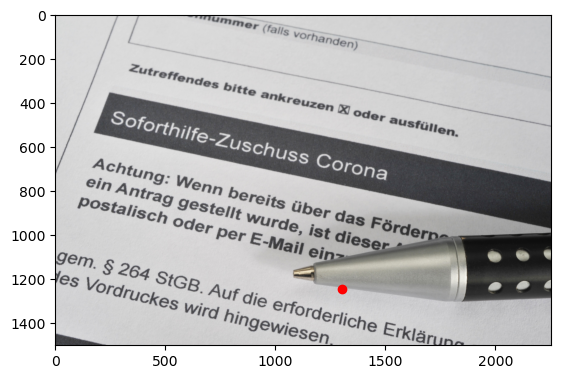

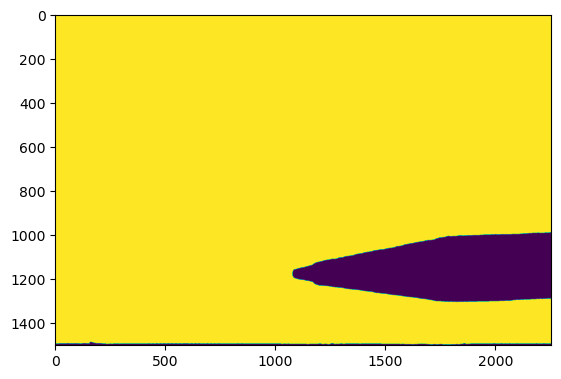

In [63]:
plt.imshow(img.int())
plt.plot(point_coords[0][0][0], point_coords[0][0][1], 'ro')
plt.show()
plt.imshow(gt_masks[0], )
plt.show()

# SlimSAM

In [64]:
import torch
from SlimSAM.segment_anything import SamPredictor

print(torch.__version__)
SlimSAM_model = torch.load("./checkpoints/SlimSAM-50.pth", map_location=torch.device('cpu'))
SlimSAM_model.image_encoder = SlimSAM_model.image_encoder.module


def forward(self, x):
    x = self.patch_embed(x)
    if self.pos_embed is not None:
        x = x + self.pos_embed

    for blk in self.blocks:
        x, qkv_emb, mid_emb, x_emb = blk(x)

    x = self.neck(x.permute(0, 3, 1, 2))

    return x


device = "cpu"
import types

funcType = types.MethodType
SlimSAM_model.image_encoder.forward = funcType(forward, SlimSAM_model.image_encoder)
SlimSAM_model.to(device)
SlimSAM_model.eval()
pass

1.11.0


In [65]:
predictor = SamPredictor(SlimSAM_model)

In [66]:
predictor.set_image(img.numpy().astype(np.uint8))
masks, scores, logits = predictor.predict(
    point_coords=point_coords[0].numpy(),
    point_labels=[1],
    box=None,
    multimask_output=False,
)

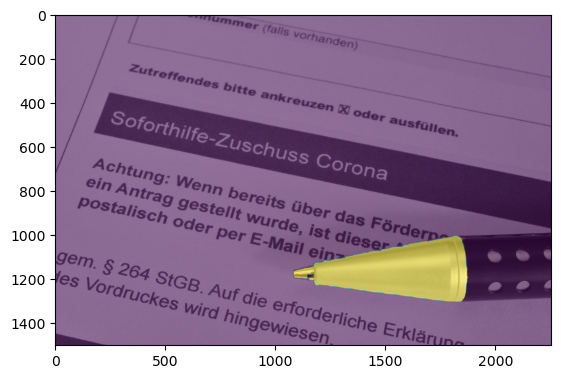

In [67]:
plt.imshow(img.int())
plt.imshow(masks[0], alpha=0.5)
plt.show()

In [68]:
from SlimSAM.segment_anything.predictor_grad import MySamPredictor

predictor = MySamPredictor(SlimSAM_model)
pred_mask, img_grad = predictor.forward(
    image=img.numpy().astype(np.uint8),
    point_coords=point_coords[0].numpy(),
    point_labels=[1],
    gt_mask=gt_masks[0:1]
)

In [69]:
img_grad

tensor([[[[1.5982, 1.5810, 1.5810,  ..., 1.2899, 1.2728, 1.2557],
          [1.5810, 1.5810, 1.5810,  ..., 1.2728, 1.2728, 1.2557],
          [1.5810, 1.5810, 1.5810,  ..., 1.2728, 1.2728, 1.2728],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[1.7633, 1.7458, 1.7458,  ..., 1.4657, 1.4482, 1.4307],
          [1.7458, 1.7458, 1.7458,  ..., 1.4482, 1.4482, 1.4307],
          [1.7458, 1.7458, 1.7458,  ..., 1.4482, 1.4482, 1.4482],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[1.9777, 1.9603, 1.9603,  ..., 1.7511, 1.7337, 1.7163],
          [1.9603, 1.9603, 1.9603,  ..., 1.7337, 1.7337, 1.7163],
          [1.9603, 1.9603, 1.9603,  ..., 1

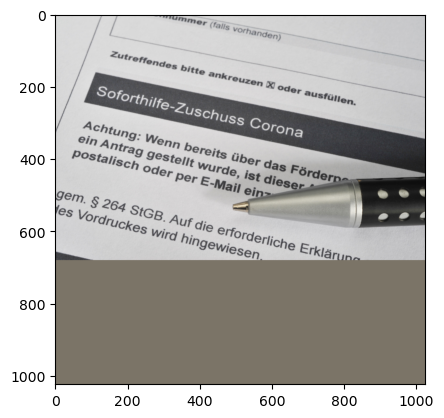

In [70]:
img_show = img_grad * predictor.model.pixel_std + predictor.model.pixel_mean

plt.imshow(img_show[0].detach().int().numpy().transpose(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


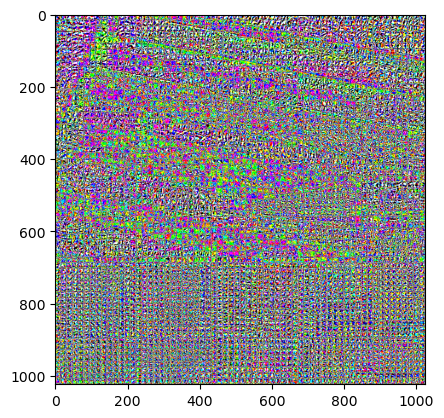

In [71]:
img_FGSM_grad = img_grad.grad / torch.abs(img_grad.grad)

plt.imshow(img_FGSM_grad[0].detach().numpy().transpose(1, 2, 0))
plt.show()


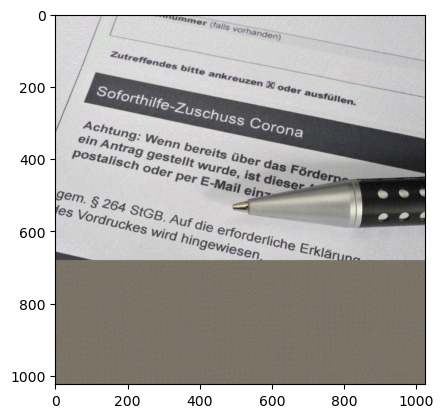

In [79]:
epsilon = 0.1
img_FGSM = img_grad + epsilon * img_FGSM_grad

img_show = img_FGSM * predictor.model.pixel_std + predictor.model.pixel_mean

plt.imshow(img_show[0].detach().int().numpy().transpose(1, 2, 0))
plt.show()

In [80]:
predictor.set_FGSM_image(img_grad + epsilon * img_FGSM_grad)
fgsm_masks, _, _ = predictor.predict(point_coords=point_coords[0].numpy(),
                                     point_labels=[1], )

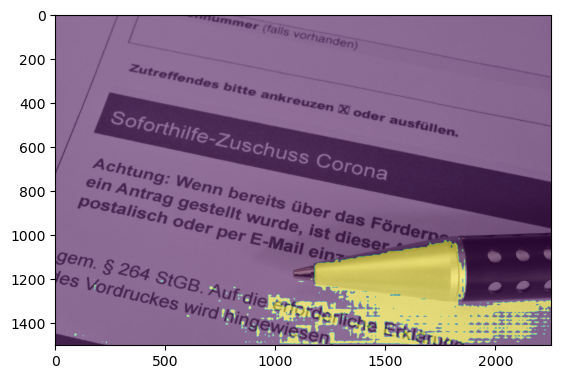

In [82]:
plt.imshow(img.int())
plt.imshow(fgsm_masks[0] > 0, alpha=0.5)
plt.show()